In [1]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import pickle
from census import Census
import sys, os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

root = '/mnt/e/julia/regional-representations-graph-model/'

sys.path.append(root + 'dataset/safegraph/')
sys.path.append(root + 'train/utils/')
sys.path.append(root + 'train/')
from models import *
from helper_funcs import *

In [2]:
cdc_health = pd.read_csv(root + 'dataset/cdc_places/raw_cdc_health_measures.csv', dtype={'GEOID': 'str'})

In [3]:
sdi_index = pd.read_csv(root + 'dataset/census/rgcsdi-2015-2019-censustract.csv', dtype={'CENSUSTRACT_FIPS': 'str'})\
    .rename(columns={'CENSUSTRACT_FIPS': 'GEOID'})

In [4]:
diversity_index = pd.read_csv(root + 'dataset/census/diversity_index.csv', dtype={'GEOID': 'str'})

In [5]:
evaluation = sdi_index[['GEOID', 'SDI_score', 'Education_LT12years_score', 'HHNo_Vehicle_score', 
                        'Nonemployed_score', 'HHCrowding_score']]\
    .merge(cdc_health[['GEOID', 'SLEEP', 'COPD', 'DEPRESSION', 'TEETHLOST', 'MHLTH', 'CHD', 'BPHIGH']], on='GEOID')\
    .merge(diversity_index, on='GEOID')
evaluation.head()

,GEOID,SDI_score,Education_LT12years_score,HHNo_Vehicle_score,Nonemployed_score,HHCrowding_score,SLEEP,COPD,DEPRESSION,TEETHLOST,MHLTH,CHD,BPHIGH,div_index
0,34003002100,28.0,39.0,39.0,91.0,1.0,31.3,4.3,14.2,6.1,10.1,5.8,NaN,0.569413
1,34003002200,16.0,28.0,22.0,58.0,1.0,32.9,4.7,15.7,8.2,11.6,5.7,NaN,0.615298
2,34003002300,16.0,27.0,51.0,27.0,1.0,32.3,4.5,15.0,7.2,10.9,5.7,NaN,0.531227
3,34003003100,23.0,24.0,73.0,52.0,32.0,34.9,3.9,14.9,7.3,11.9,4.6,NaN,0.748122
4,34003003200,59.0,53.0,81.0,10.0,77.0,35.6,4.0,14.5,8.5,12.1,4.6,NaN,0.728539


In [49]:
with open(root + 'dataset/api_keys/census_key.txt', 'r') as f:
    key = f.readline()
c = Census(key)

state_fps = ['42', '34', '36','25']

var = ['NAME', 'B01001_001E', 'B01001_026E', 'B01001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E', 'B02001_007E', 
        'B01001H_001E', 'B01001I_001E', 'B01002_001E', 'B19013_001E', 'B19083_001E', 'B27001_001E', 
        'B08101_009E', 'B08101_017E', 'B08101_025E', 'B08101_033E', 'B08101_049E', 'B15003_017E',
           'B15003_022E', 'B15003_023E', 'B15003_025E']

name = ['NAME', 'total_pop',  'num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 
        'total_other', 'total_white', 'total_latino', 'total_median_age', 'median_household_income', 
        'income_gini_index', 'health_insurance_coverage', 'num_drive_alone', 
        'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

name_compute_ratio = ['num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 'total_other', 'total_white', 'total_latino', 'health_insurance_coverage', 
                      'num_drive_alone', 'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

cols = name + ['state', 'county', 'tract']
census_df = pd.DataFrame(columns=cols)
for state in state_fps:
    census = c.acs5.state_county_tract(fields = var,
                                        state_fips = state,
                                        county_fips = '*',
                                        tract = "*",
                                        year = 2020)
    
    df = pd.DataFrame(census)
    df.rename(columns=dict(zip(var, name)), inplace=True)
    for col in name_compute_ratio:
        df[col] = df[col]/df['total_pop']
        
    # combine embeddings with labels
    df['GEOID'] = df['state'].astype(str) + df['county'].astype(str) + df['tract'].astype(str)
        
    census_df = pd.concat([census_df, df])

/tmp/ipykernel_20421/1712983476.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(evaluation.corr(), annot=True)


<Axes: >

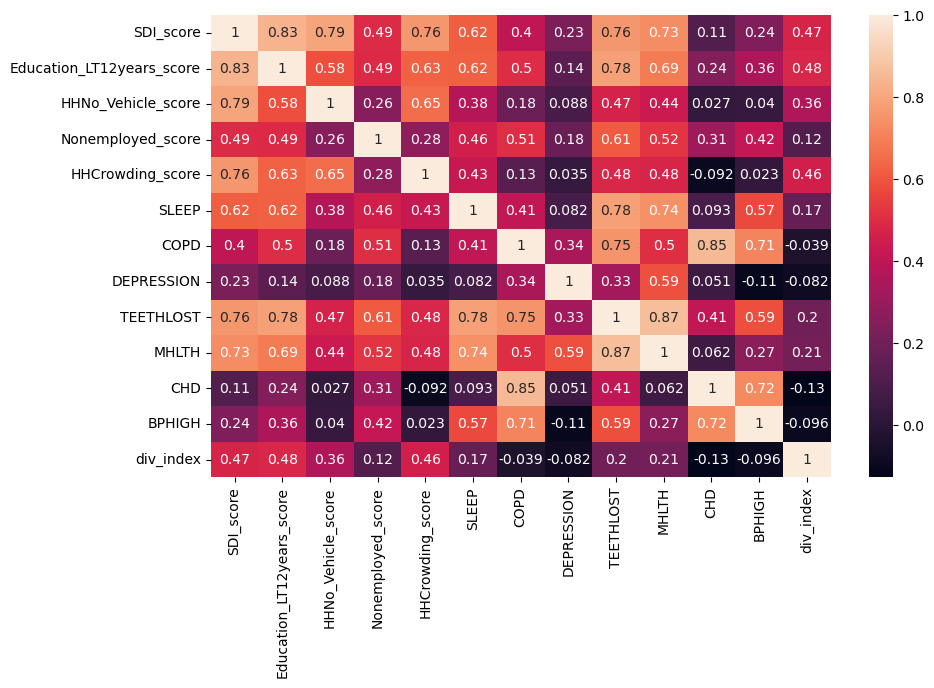

In [9]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(evaluation.corr(), annot=True)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# predict_labels = ['total_white', 'total_black', 'total_median_age', 'median_household_income', 'income_gini_index']#, 'health_insurance_coverage']

predict_labels = [ 'total_black', 'total_asian', 'total_white', 'total_latino', 'total_median_age', 'median_household_income', 
        'income_gini_index', 'health_insurance_coverage', 'num_drive_alone', 
        'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']


predict_labels = evaluation.columns[1:]
def train_test(df_emb, title, model1=LogisticRegression(), model2=RandomForestClassifier(), dim_reducer=PCA(), predict_labels=None):
    
    print(f'------------------------{title}------------------------------')
    model1_scores = []
    model2_scores = []
    labels = []
    
    for lab in predict_labels:
        X = np.array(df_emb[[i for i in range(0, 200)]])
        y = np.array(df_emb[lab])

        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        # binarize labels
        #     pre = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal')
        pre = preprocessing.Binarizer(threshold=np.median(y_train))
        pre.fit(y_train)

        y_train = np.ravel(pre.transform(y_train))
        y_test =  np.ravel(pre.transform(y_test))

#         print(f'\n------Feature {lab}------')
#         print(f'\n  --{model1}--')
#         steps = [
#             ('preprocess', preprocessing.StandardScaler()),
#             ('select', dim_reducer),
#             ('clf', LogisticRegression(max_iter=300)),
#             ]
#         pipe = Pipeline(steps)
#         param_grid = {
#             'select__n_components': [50, 100, 200]
#             }

#         cv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=False, scoring='accuracy')
#         try:
#             cv.fit(X_train, y_train)
#         except:
#             continue
#         print(f'Train: {cv.score(X_train, y_train)}')
#         print(f'Test: {cv.score(X_test, y_test)}')
#         print(f'Best params: {cv.best_params_}')
#         print(f'Best estimator: {cv.best_estimator_}')
#         print(f'Best CV Score: {cv.best_score_}')
#         model1_scores.append(cv.score(X_test, y_test))


        print(f'\n  --{model2}--')
        steps = [
            ('preprocess', preprocessing.StandardScaler()),
            ('select', dim_reducer),
            ('clf', RandomForestClassifier()),
             ]


        param_grid = {
            'clf__min_samples_split': [5, 10],
            'clf__max_depth': [3,  7],
            'clf__n_estimators': [100],
            'select__n_components': [50, 100]
            }
        pipe = Pipeline(steps)

        cv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=False, scoring='accuracy')
        cv.fit(X_train, y_train)
        print(f'Train: {cv.score(X_train, y_train)}')
        print(f'Test: {cv.score(X_test, y_test)}')
        print(f'Best params: {cv.best_params_}')
        print(f'Best estimator: {cv.best_estimator_}')
        print(f'Best CV Score: {cv.best_score_}')
        model2_scores.append(cv.score(X_test, y_test))

        labels.append(lab)
    
    return model1_scores, model2_scores, labels


In [7]:
# results_dict = dict()
with open('results_othervariables.pickle', 'rb') as handle:
    results_dict = pickle.load(handle)

In [8]:
results_dict

{'all_valid_data/': {'landsat': {'rf': [0.7562326869806094,
    0.6481994459833795,
    0.8310249307479224,
    0.6135734072022161,
    0.7229916897506925,
    0.6329639889196675,
    0.5443213296398892,
    0.5886426592797784,
    0.6759002770083102,
    0.6620498614958449,
    0.556786703601108,
    0.5290858725761773,
    0.6135734072022161]},
  'mobility': {'rf': [0.7894736842105263,
    0.7368421052631579,
    0.8822714681440443,
    0.6939058171745153,
    0.7479224376731302,
    0.7742382271468145,
    0.7077562326869806,
    0.778393351800554,
    0.7645429362880887,
    0.760387811634349,
    0.6246537396121884,
    0.760387811634349,
    0.7105263157894737]},
  'distance': {'rf': [0.8282548476454293,
    0.7839335180055401,
    0.9002770083102493,
    0.7174515235457064,
    0.7825484764542936,
    0.8185595567867036,
    0.7354570637119113,
    0.7839335180055401,
    0.817174515235457,
    0.8157894736842105,
    0.6759002770083102,
    0.7700831024930748,
    0.77423822714

In [9]:
# read in embeddings
node_list_scenario = 'all_valid_data/'
node_list_path = root + f'dataset/preprocessed_data/{node_list_scenario}node_list.csv'
node_list = pd.read_csv(node_list_path, dtype={'GEOID': str})
num_nodes = node_list.shape[0]
idx_node_map = dict(zip(node_list.index, node_list['GEOID']))

model = NodeEmbeddings(num_nodes, embedding_dim=200)

for param in model.parameters():
      embeddings = param
        
census_df = evaluation

In [10]:
l1 = ['distance']
l2 = ['mobility-distance/']
for data_type, scenario in zip(l1,  l2):
    
    if scenario not in results_dict.keys():
        results_dict[scenario] = {}
    if data_type not in results_dict[scenario].keys():
        results_dict[scenario][data_type] = {}
        
    node_list_scenario = 'all_valid_data/'
    savedir=root +  f'train/outputs/{scenario}evaluate/'
    if not os.path.exists(savedir):
        createCleanDir(savedir)

    # read in embeddings
    node_list_path = root + f'dataset/preprocessed_data/{node_list_scenario}node_list.csv'
    node_list = pd.read_csv(node_list_path, dtype={'GEOID': str})
    num_nodes = node_list.shape[0]
    idx_node_map = dict(zip(node_list.index, node_list['GEOID']))

    
    search = root + f'train/outputs/{scenario}{data_type}/'
    if os.path.exists(search):
        for f in os.listdir(search):
            if 'last.tar' in f:
                pre_trained = search + f
                break


    checkpoint=torch.load(pre_trained)
    model = NodeEmbeddings(num_nodes, embedding_dim=200)
    model.load_state_dict(checkpoint['model_state_dict'],strict=False)

    for param in model.parameters():
          embeddings = param

    df = pd.DataFrame(embeddings.detach().numpy()).reset_index()
    df_idx = pd.DataFrame.from_dict(idx_node_map, orient='index').reset_index().rename(columns={0:'GEOID'})
    df_emb = df_idx.merge(df, on='index')

    df_emb = df_emb.merge(census_df, on='GEOID', how='left')


#     df_emb.drop(columns=['state', 'county', 'tract', 'index'], inplace=True)
    df_emb.drop(index=df_emb[df_emb.isna().any(axis=1)].index, inplace=True)
    
    title=f'Classification - {scenario} - PCA'
    logistic, rf, labels = train_test(df_emb, title, model1=LogisticRegression(), model2=RandomForestClassifier(), dim_reducer=PCA(), predict_labels=predict_labels)
    
    
    results_dict[scenario][data_type]['rf'] = rf.copy()

results_dict['labels'] = labels

------------------------Classification - mobility-distance/ - PCA------------------------------

  --RandomForestClassifier()--
Train: 0.8913546000924641
Test: 0.8351800554016621
Best params: {'clf__max_depth': 7, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'select__n_components': 100}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=100)),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=10))])
Best CV Score: 0.8238516807800872

  --RandomForestClassifier()--
Train: 0.8728617660656496
Test: 0.7853185595567868
Best params: {'clf__max_depth': 7, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'select__n_components': 50}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=50)),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=10))])
Best CV Score: 0.80027264562

In [57]:
data_type = 'random_embeddings'
scenario = 'random_embeddings/'

if scenario not in results_dict.keys():
    results_dict[scenario] = {}
    if data_type not in results_dict[scenario].keys():
        results_dict[scenario][data_type] = {}
            
# # read in embeddings
# node_list_path = root + f'dataset/preprocessed_data/{node_list_scenario}node_list.csv'
# node_list = pd.read_csv(node_list_path, dtype={'GEOID': str})
# num_nodes = node_list.shape[0]
# idx_node_map = dict(zip(node_list.index, node_list['GEOID']))

# search = root + f'train/outputs/{scenario}{data_type}/'
# if os.path.exists(search):
#     for f in os.listdir(search):
#         if 'last.tar' in f:
#             pre_trained = search + f
#             break
                
# checkpoint=torch.load(pre_trained)
model = NodeEmbeddings(num_nodes, embedding_dim=200)
# model.load_state_dict(checkpoint['model_state_dict'],strict=False)

for param in model.parameters():
    embeddings = param
    
df = pd.DataFrame(embeddings.detach().numpy()).reset_index()
df_idx = pd.DataFrame.from_dict(idx_node_map, orient='index').reset_index().rename(columns={0:'GEOID'})
df_emb = df_idx.merge(df, on='index')

df_emb = df_emb.merge(census_df, on='GEOID', how='left')


# df_emb.drop(columns=['state', 'county', 'tract', 'index'], inplace=True)
df_emb.drop(index=df_emb[df_emb.isna().any(axis=1)].index, inplace=True)

title=f'Classification - {scenario} - PCA'
logistic, rf, labels = train_test(df_emb, title, model1=LogisticRegression(), model2=RandomForestClassifier(), dim_reducer=PCA(), predict_labels=predict_labels)

results_dict[scenario][data_type]['rf'] = rf.copy()

------------------------Classification - random_embeddings/ - PCA------------------------------

  --RandomForestClassifier()--
Train: 0.9017800381436745
Test: 0.5224022878932316
Best params: {'clf__max_depth': 7, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'select__n_components': 50}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=50)),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=5))])
Best CV Score: 0.5206692406692406

  --RandomForestClassifier()--
Train: 0.8944691671964399
Test: 0.47664442326024786
Best params: {'clf__max_depth': 7, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'select__n_components': 50}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=50)),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=5))])
Best CV Score: 0.5041365735483383

In [61]:
# stdoutOrigin=sys.stdout 
# sys.stdout = open(savedir + 'ML_PCA_classification_log.txt', "w")
# title=f'Classification - {scenario} - PCA'
# logistic, rf, labels = train_test(df_emb, title, model1=LogisticRegression(), model2=RandomForestClassifier(), dim_reducer=PCA(), predict_labels=predict_labels)

# sys.stdout.close()
# sys.stdout=stdoutOrigin

------------------------Classification - mobility-distance/ - PCA------------------------------

  --RandomForestClassifier()--
Train: 0.7832167832167832
Test: 0.6482364156339371
Best params: {'clf__max_depth': 7, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'select__n_components': 100}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=100)),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=10))])
Best CV Score: 0.6522557851969617

  --RandomForestClassifier()--
Train: 0.6373172282263191
Test: 0.5862726406101049
Best params: {'clf__max_depth': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'select__n_components': 50}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=50)),
                ('clf',
                 RandomForestClassifier(max_depth=3, min_samples_split=5))])
Best CV Score: 0.5626163979105

Train: 0.8226319135410044
Test: 0.6701620591039085
Best params: {'clf__max_depth': 7, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'select__n_components': 50}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=50)),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=5))])
Best CV Score: 0.7053413076942489

  --RandomForestClassifier()--
Train: 0.8343928798474253
Test: 0.7378455672068637
Best params: {'clf__max_depth': 7, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'select__n_components': 100}
Best estimator: Pipeline(steps=[('preprocess', StandardScaler()),
                ('select', PCA(n_components=100)),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=10))])
Best CV Score: 0.7263189239659827

  --RandomForestClassifier()--
Train: 0.8445645263827082
Test: 0.7530981887511916
Best params: {'clf__max_depth': 7, 'clf__

In [11]:
interesting_variable_indexes = [i for i in range(0, len(labels))]
plot_labels = labels

# interesting_variable_indexes = [idx for idx, i in enumerate(labels) if i in ['total_black', 'total_white', 'total_median_age', 
#                                             'median_household_income', 'num_public_transit', 'num_walk',
#                                             'doctorate_degree' ]]

# plot_labels = [labels[idx] for idx in interesting_variable_indexes]

In [31]:
plot_labels

['SDI_score',
 'Education_LT12years_score',
 'HHNo_Vehicle_score',
 'Nonemployed_score',
 'HHCrowding_score',
 'SLEEP',
 'COPD',
 'DEPRESSION',
 'TEETHLOST',
 'MHLTH',
 'CHD',
 'BPHIGH',
 'div_index']

In [33]:
results_dict.keys()

dict_keys(['all_valid_data/', 'just_mobility/', 'just_distance/', 'all_valid_data_finetunedresnet/', 'labels', 'random_embeddings/'])

In [12]:
S1_rf = results_dict['all_valid_data/']['landsat']['rf']
S2_rf = results_dict['all_valid_data/']['mobility']['rf']
S3_rf = results_dict['all_valid_data/']['distance']['rf']
S4_rf = results_dict['mobility-distance/']['distance']['rf']

In [45]:
# with open('results_othervariables.pickle', 'wb') as handle:
#     b = pickle.dump(results_dict, handle)

In [14]:
import seaborn as sns

/tmp/ipykernel_23148/2113296733.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


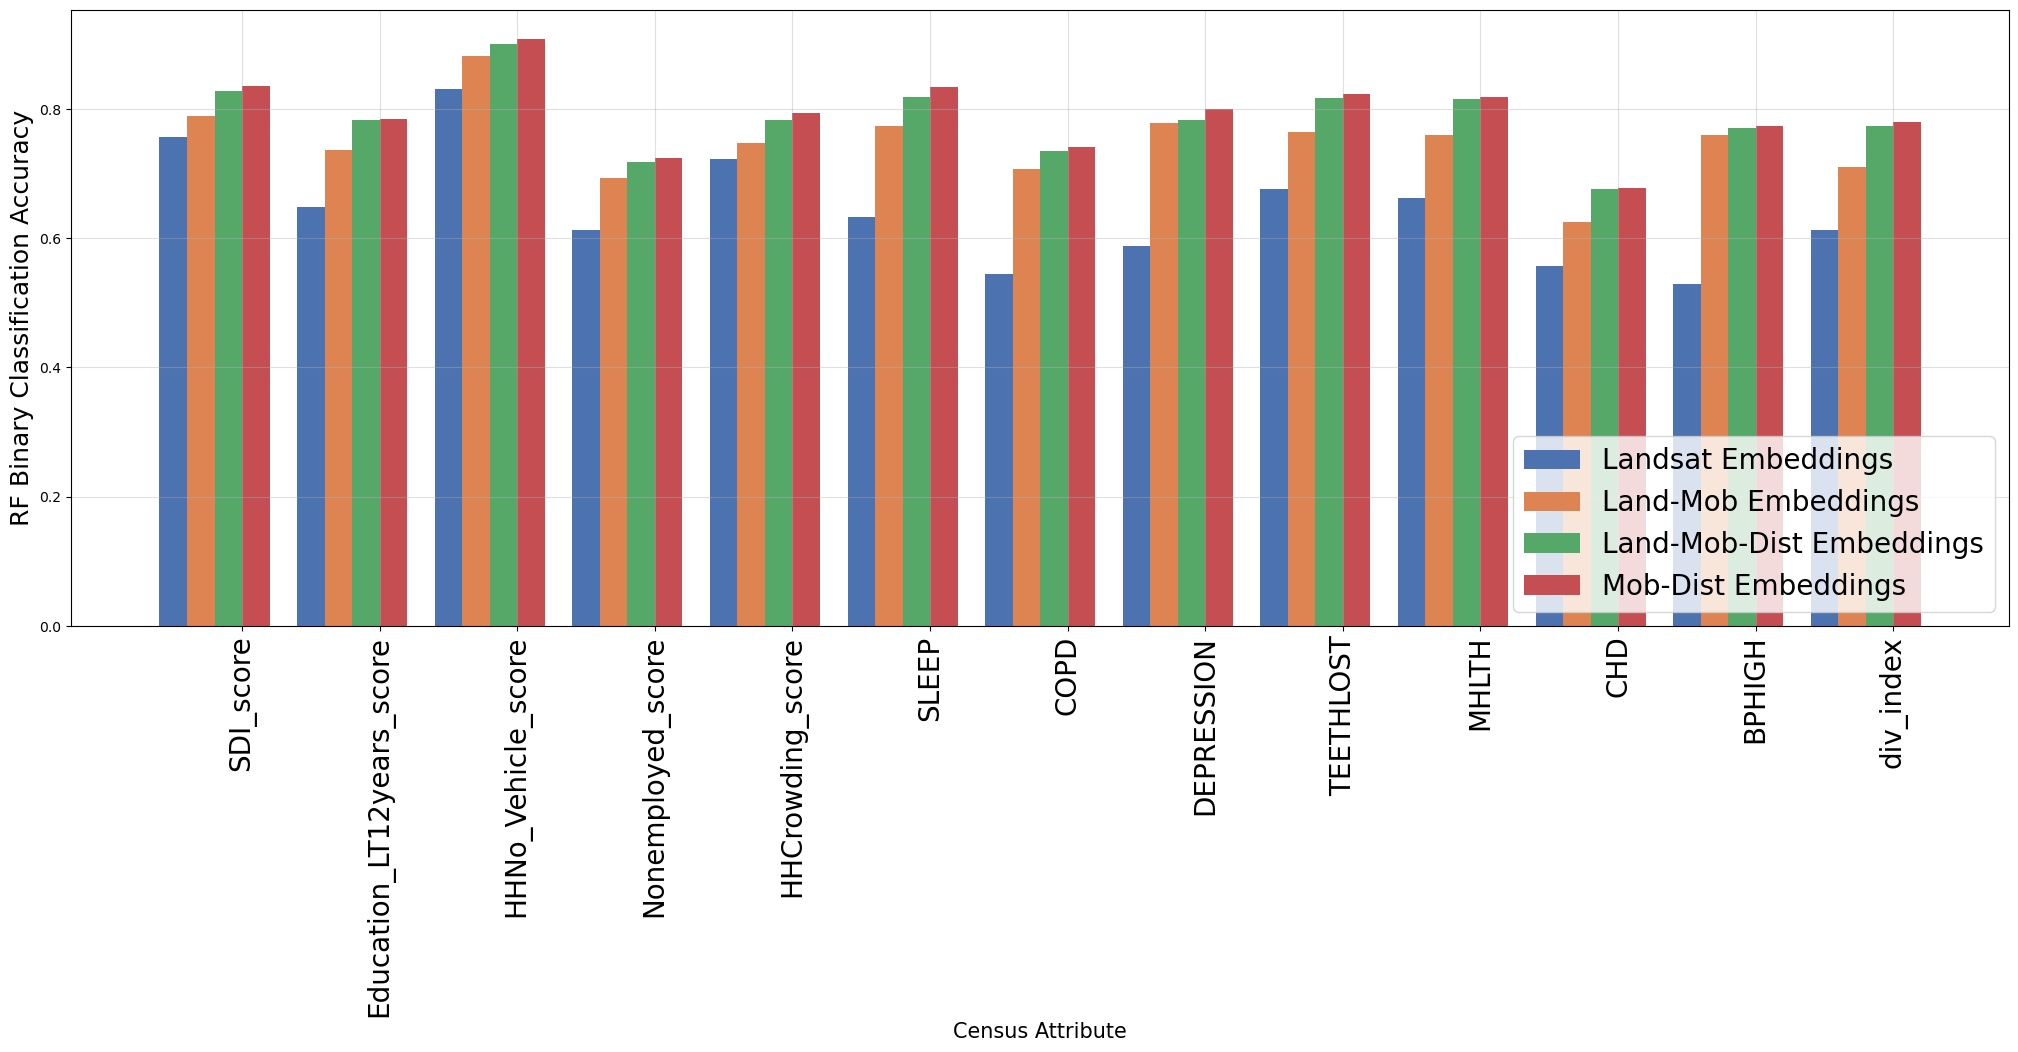

In [15]:
width = 0.2
x = np.arange(len(plot_labels))
plt.style.use('seaborn-dark-palette')

plt.figure(figsize=(25, 8))
# plt.bar(x-0.21, logistic, width, label='Logistic Regression', color=sns.color_palette('deep', 2)[0])
S1 = [S1_rf[idx] for idx in interesting_variable_indexes]
S2 = [S2_rf[idx] for idx in interesting_variable_indexes]
S3 = [S3_rf[idx] for idx in interesting_variable_indexes]
S4 = [S4_rf[idx] for idx in interesting_variable_indexes]

plt.bar(x-0.5, S1, width, label='Landsat Embeddings', color=sns.color_palette('deep', 4)[0])
plt.bar(x-0.3, S2, width, label='Land-Mob Embeddings', color=sns.color_palette('deep', 4)[1])
plt.bar(x-0.1, S3, width, label='Land-Mob-Dist Embeddings', color=sns.color_palette('deep', 4)[2])
plt.bar(x+0.1, S4, width,  label='Mob-Dist Embeddings', color=sns.color_palette('deep', 4)[3])
plt.xticks(ticks=x, labels=plot_labels, rotation=90, fontsize=20)
plt.ylabel('RF Binary Classification Accuracy', fontsize=18)
plt.xlabel('Census Attribute', fontsize=15)
plt.legend(fontsize=20, loc=4)
# plt.title(f'Preprocessing Comparison', fontsize=18)
plt.grid(alpha=0.4)

/tmp/ipykernel_65436/3561950930.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


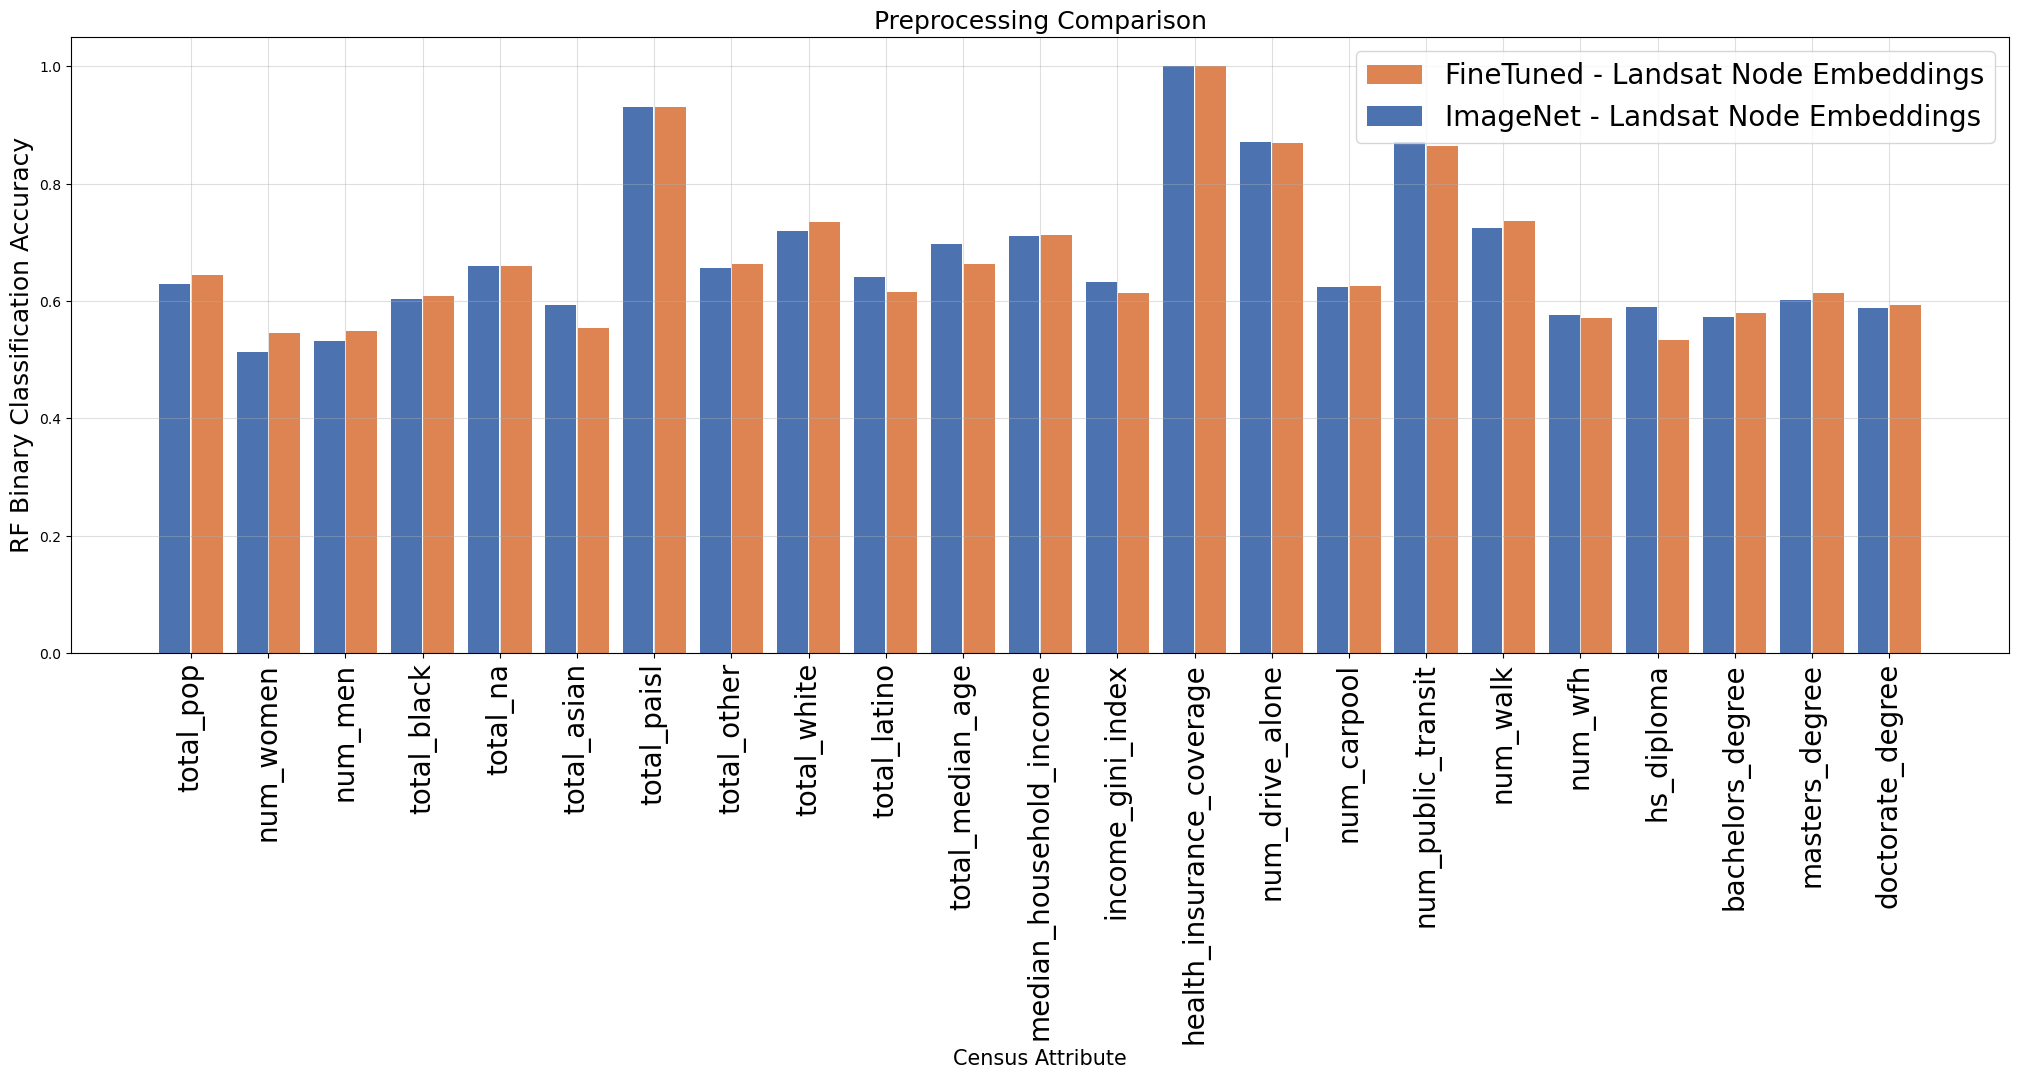

In [52]:
width = 0.40
x = np.arange(len(plot_labels))
plt.style.use('seaborn-dark-palette')

plt.figure(figsize=(25, 8))
# plt.bar(x-0.21, logistic, width, label='Logistic Regression', color=sns.color_palette('deep', 2)[0])
S1 = [S1_rf[idx] for idx in interesting_variable_indexes]
S2 = [S2_rf[idx] for idx in interesting_variable_indexes]

plt.bar(x+0.21, S1, width, label='FineTuned - Landsat Node Embeddings', color=sns.color_palette('deep', 2)[1])
plt.bar(x-0.21, S2, width,  label='ImageNet - Landsat Node Embeddings', color=sns.color_palette('deep', 2)[0])
plt.xticks(ticks=x, labels=plot_labels, rotation=90, fontsize=20)
plt.ylabel('RF Binary Classification Accuracy', fontsize=18)
plt.xlabel('Census Attribute', fontsize=15)
plt.legend(fontsize=20)
plt.title(f'Preprocessing Comparison', fontsize=18)
plt.grid(alpha=0.4)

# if not os.path.exists(savedir):
#     createCleanDir(savedir)
# plt.savefig(savedir + 'upsampled_comparison_pca_classifier_accuracy')

# 2)  UMAP instead of PCA for dimensionality reduction

Should I standardize before UMAP? Site says yes to standardize if the features are not relational (i.e., longitude, latitude), 

In [10]:
import umap
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0, n_components=100, metric='euclidean', random_state=42)

In [ ]:
stdoutOrigin=sys.stdout 
sys.stdout = open(savedir + 'ML_UMAP_classification_log.txt', "w")
title=f'Classification - {scenario} - UMAP'
logistic, rf, labels = train_test(df_emb, title, model1=LogisticRegression(), model2=RandomForestClassifier(), dim_reducer=umap_reducer, predict_labels=predict_labels)

sys.stdout.close()
sys.stdout=stdoutOrigin

/home/julia/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
width = 0.40
x = np.arange(len(labels))

plt.figure(figsize=(15, 8))
plt.bar(x-0.21, logistic, width, label='Logistic Regression', color='pink')
plt.bar(x+0.21, rf, width, label='Random Forest', color='navy')

plt.xticks(ticks=x, labels=predict_labels, rotation=60, fontsize=15)
plt.ylabel('R^2', fontsize=15)
plt.xlabel('Census Attribute', fontsize=15)
plt.legend(fontsize=15)
plt.title(f'Classification Performance: {scenario}', fontsize=18)

plt.savefig(savedir + 'umap_classification_accuracy')